In [278]:
import pandas as pd
import pandas_datareader as web
import yfinance as yf

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from numpy.linalg import inv, eig, svd
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix 
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from matplotlib.ticker import FuncFormatter

In [135]:
# load dataset
#scraping wikipedia to fetch S&P 500 stock list
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
SP_stocks = pd.read_html(snp500url)[0]
SP_tickers = SP_stocks['Symbol'].to_list()

dji = (
    pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1]
)
dji_symbols = dji.Symbol.tolist()

In [179]:
def download_stocks(tickers,start='2014-01-01',end='2019-01-01'):
    return yf.download(tickers, start = start, end = end)

def remove_null(df, cutoff = .99):
    df = df.dropna(thresh=int(df.shape[0]*cutoff),axis=1)
    df = df.dropna(thresh=int(df.shape[1]*cutoff))
    return df

def winsorize(df,q=.025):
    clipped = df.clip(lower=df.quantile(q=q),
                   upper=df.quantile(q=1-q),
                   axis=1)
    return clipped

def df_scaler(df):
    scaler = StandardScaler().fit(df)
    return scaler

def train_test_split(df,percentage = .8):
    
    train_size = int(len(df)*percentage)
    train_set = df[:train_size]
    test_set = df[train_size:]
    
    return train_set, test_set

def normalize_data(df_train,df_test):
    scaler = StandardScaler().fit(df_train)
    
    train = pd.DataFrame(scaler.transform(df_train),
                         columns = df_train.columns,
                         index = df_train.index)
    test = pd.DataFrame(scaler.transform(df_test),
                        columns = df_test.columns,
                        index = df_test.index)
    
    return train, test

In [180]:
SP_data = download_stocks(SP_tickers)['Adj Close']
SP_data.index = pd.to_datetime(SP_data.index)

dji_data = download_stocks(dji_symbols)['Adj Close']
dji_data.index = pd.to_datetime(dji_data.index)

SP_data = remove_null(SP_data)
dji_data = remove_null(dji_data)

[*********************100%***********************]  503 of 503 completed

11 Failed downloads:
- OTIS: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- FOXA: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- CARR: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- BRK.B: No timezone found, symbol may be delisted
- CTVA: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- OGN: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- GEHC: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- BF.B: No data found for this date range, symbol may be delisted
- FOX: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- DOW: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- CEG: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
[*********************100%***********************]  30 of 30 completed

1 Failed download:
- DOW: Data doesn

In [181]:
print(SP_data.isna().sum().sum())
print(dji_data.isna().sum().sum())

0
0


In [870]:
#SP_returns = SP_data.pct_change().dropna()
#dji_returns = dji_data.pct_change().dropna()

#SP_log_returns = np.log(SP_data/SP_data.shift(1))[1:]
#dji_log_returns = np.log(dji_data/dji_data.shift(1))[1:]
#
#SP_log_returns = winsorize(SP_log_returns)
#dji_log_returns = winsorize(dji_log_returns)

SP_returns = SP_data.pct_change().dropna()
dji_returns = dji_data.pct_change().dropna()

SP_returns = winsorize(SP_returns)
dji_returns = winsorize(dji_returns)

In [902]:
#SP_train, SP_test = train_test_split(SP_log_returns)
#dji_train, dji_test = train_test_split(dji_log_returns)

SP_train, SP_test = train_test_split(SP_returns)
dji_train, dji_test = train_test_split(dji_returns)

In [903]:
SP_train_scaled, SP_test_scaled = normalize_data(SP_train,SP_test)
dji_train_scaled, dji_test_scaled = normalize_data(dji_train,dji_test)

In [904]:
print('Statistics for SP-500 test set')
print(f'Average normalized return: {SP_test_scaled.mean().mean()}')
print(f'Average standard deviation: {SP_test_scaled.std().mean()}')

Statistics for SP-500 test set
Average normalized return: -0.049224048390067436
Average standard deviation: 1.1335713431863537


In [905]:
print('Statistics for DJI test set')
print(f'Average normalized return: {dji_test_scaled.mean().mean()}')
print(f'Average standard deviation: {dji_test_scaled.std().mean()}')

Statistics for DJI test set
Average normalized return: -0.029227189165805963
Average standard deviation: 1.2164679808753642


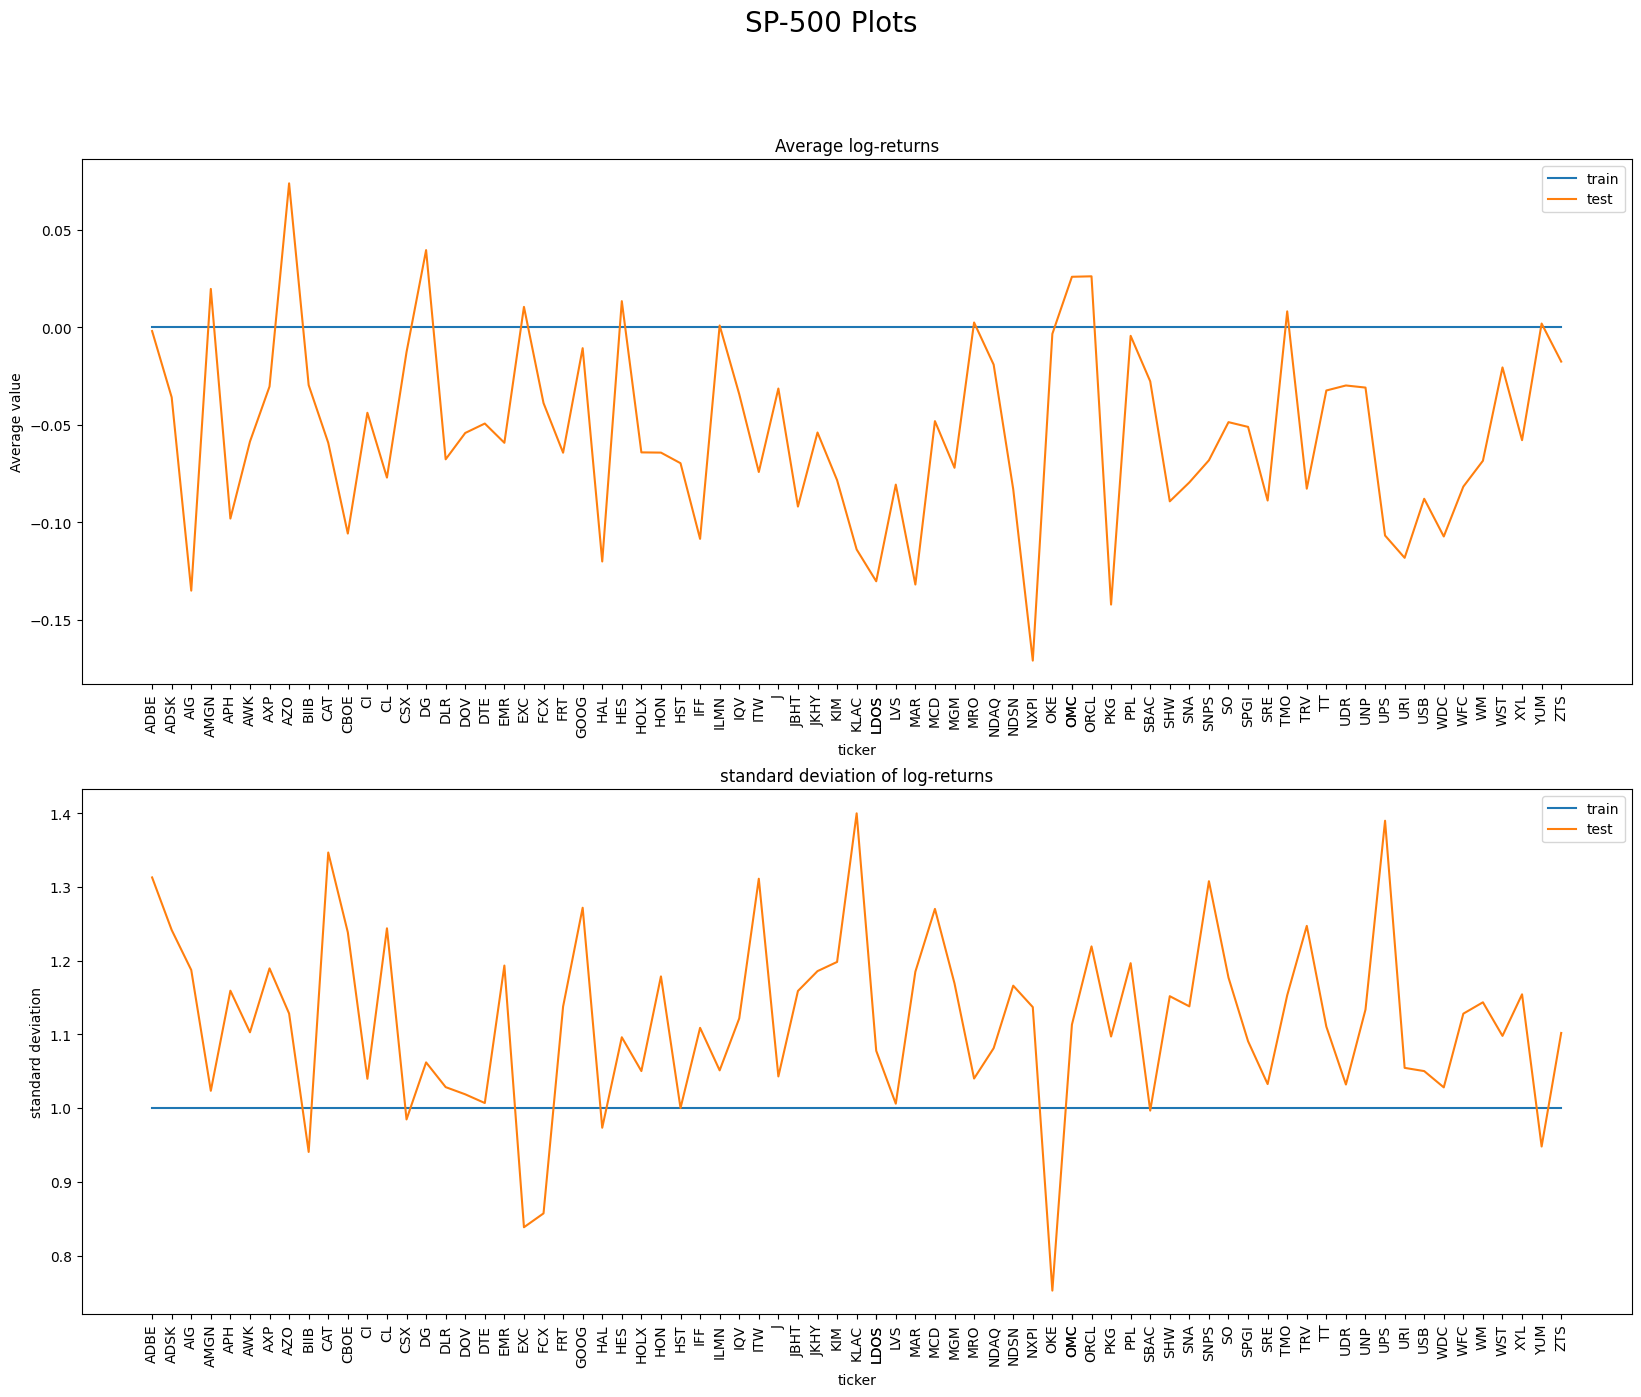

In [906]:
fig, axes = plt.subplots(2,sharex=False)
fig.set_size_inches(20, 15)

np.random.seed(110)

random_stocks = sorted(np.random.choice(SP_train_scaled.shape[1],75))
random_tickers = list(SP_train_scaled.columns[random_stocks])

SP_train_scaled_sample = SP_train_scaled[random_tickers]
SP_test_scaled_sample = SP_test_scaled[random_tickers]

axes[0].plot(SP_train_scaled_sample.mean(),label='train')
axes[0].plot(SP_test_scaled_sample.mean(),label='test')
axes[0].set_title('Average log-returns')
axes[0].set_ylabel('Average value')
axes[0].legend()

axes[0].set_xlabel('ticker')
axes[0].set_xticks(random_tickers)
axes[0].set_xticklabels(random_tickers,rotation=90)

#plt.draw()
#axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)

axes[1].plot(SP_train_scaled_sample.std(),label='train')
axes[1].plot(SP_test_scaled_sample.std(),label='test')
axes[1].set_title('standard deviation of log-returns')
axes[1].set_ylabel('standard deviation')
axes[1].legend()


axes[1].set_xlabel('ticker')
axes[1].set_xticks(random_tickers)
axes[1].set_xticklabels(random_tickers,rotation=90);

plt.suptitle('SP-500 Plots',fontsize=20)

plt.show();

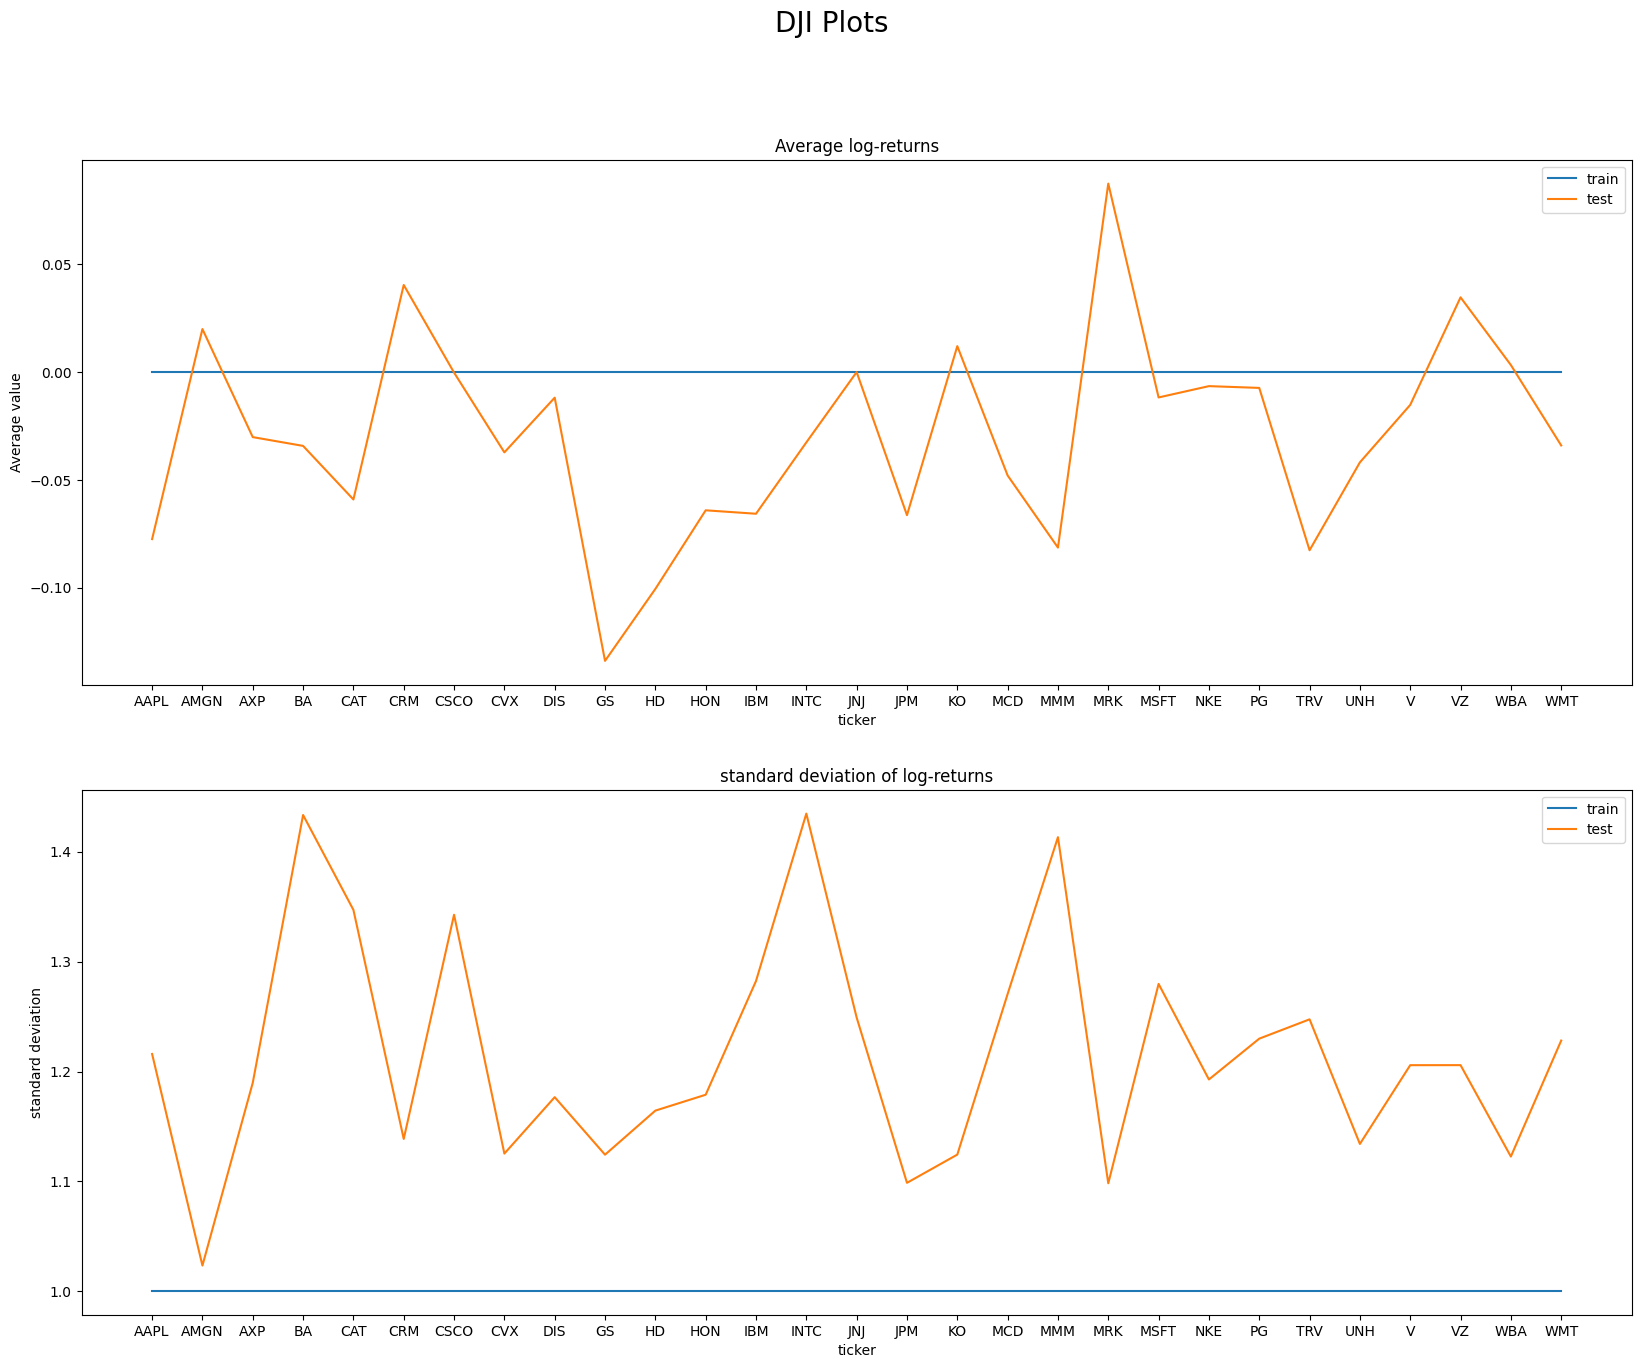

In [907]:
fig, axes = plt.subplots(2,sharex=False)
fig.set_size_inches(20, 15)

axes[0].plot(dji_train_scaled.mean(),label='train')
axes[0].plot(dji_test_scaled.mean(),label='test')
axes[0].set_title('Average log-returns')
axes[0].set_ylabel('Average value')
axes[0].legend()

axes[0].set_xlabel('ticker')
#axes[0].set_xticks(random_tickers)
#axes[0].set_xticklabels(random_tickers,rotation=90)

#plt.draw()
#axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)

axes[1].plot(dji_train_scaled.std(),label='train')
axes[1].plot(dji_test_scaled.std(),label='test')
axes[1].set_title('standard deviation of log-returns')
axes[1].set_ylabel('standard deviation')
axes[1].legend()


axes[1].set_xlabel('ticker')


plt.suptitle('DJI Plots',fontsize=20)

plt.show();

In [908]:
SP_train_cov = SP_train_scaled.cov()
dji_train_cov = dji_train_scaled.cov()

In [909]:
PCA_SP = PCA().fit(SP_train_scaled)
PCA_DJI = PCA().fit(dji_train_scaled)

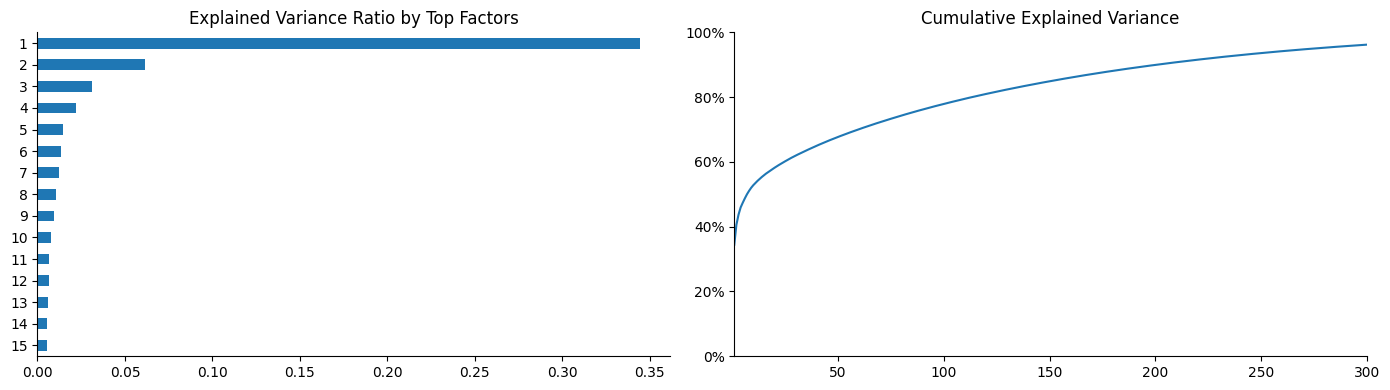

In [910]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(PCA_SP.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 300))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.tight_layout()

In [911]:
SP_train_scaled = (SP_train-SP_train.mean())/SP_train.std()
SP_test_scaled = (SP_test-SP_train.mean())/SP_train.std()

dji_train_scaled = (dji_train-dji_train.mean())/dji_train.std()
dji_test_scaled = (dji_test-dji_train.mean())/dji_train.std()

In [912]:
SP_train_corr = 1/(SP_train_scaled.shape[0]-1)*SP_train_scaled.T.dot(SP_train_scaled)
dji_train_corr = 1/(dji_train_scaled.shape[0]-1)*dji_train_scaled.T.dot(dji_train_scaled)

In [913]:
SP_train_cov = (1/(SP_train.shape[0]-1)
                *(SP_train-SP_train.mean()).T.dot(SP_train-SP_train.mean()))

dji_train_cov = (1/(dji_train.shape[0]-1)
                *(dji_train-dji_train.mean()).T.dot(dji_train-dji_train.mean()))

In [915]:
PCA_SP = PCA().fit(SP_train_scaled)
PCA_DJI = PCA().fit(dji_train_scaled)

In [916]:
dji_eigvals, dji_eigvecs = np.linalg.eigh(dji_train_corr)

dji_eigvals = dji_eigvals[::-1]
dji_eigvecs = dji_eigvecs[:,::-1]


print(np.allclose(PCA_DJI.explained_variance_ratio_,(dji_eigvals/np.sum(dji_eigvals))))

print(np.allclose(np.abs(np.dot(PCA_DJI.components_,dji_eigvecs)),
            np.eye(dji_eigvecs.shape[0])))

True
True


In [917]:
SP_eigvals, SP_eigvecs = np.linalg.eigh(SP_train_corr)

print(np.allclose(PCA_SP.explained_variance_ratio_[::-1],(SP_eigvals/np.sum(SP_eigvals))))

print(np.allclose(np.abs(np.dot(PCA_SP.components_,SP_eigvecs[::,::-1])),
            np.eye(SP_eigvecs.shape[0])))

True
True


In [918]:
SP_explained_variance = (SP_eigvals/np.sum(SP_eigvals))

DJI_explained_variance = (dji_eigvals/np.sum(dji_eigvals))

In [919]:
dji_evecs_std = (dji_eigvecs.T/(dji_train.std().values)).T

np.allclose((dji_train.dot(dji_evecs_std)).corr().values,np.eye(dji_evecs_std.shape[0]))

True

In [920]:
SP_evecs_std = (SP_eigvecs.T/(SP_train.std().values)).T

np.allclose((SP_train.dot(SP_evecs_std)).corr().values,np.eye(SP_evecs_std.shape[0]))

True

In [921]:
dji_eport_train = dji_train.dot(dji_evecs_std)
dji_eport_test = dji_test.dot(dji_evecs_std)

SP_eport_train = SP_train.dot(SP_evecs_std)
SP_eport_test = SP_test.dot(SP_evecs_std)


SP_eport = SP_data.dot(SP_evecs_std)
DJI_eport = dji_data.dot(dji_evecs_std)

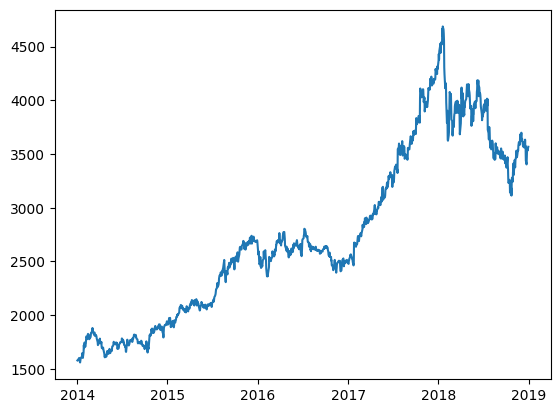

In [922]:
plt.plot(-1*SP_eport.iloc[:,0])
plt.show()

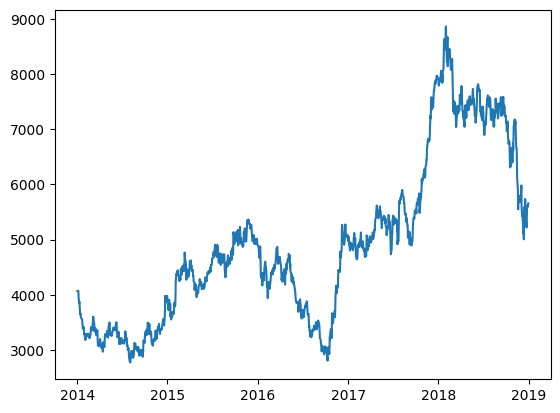

In [923]:
plt.plot(-1*DJI_eport.iloc[:,4])

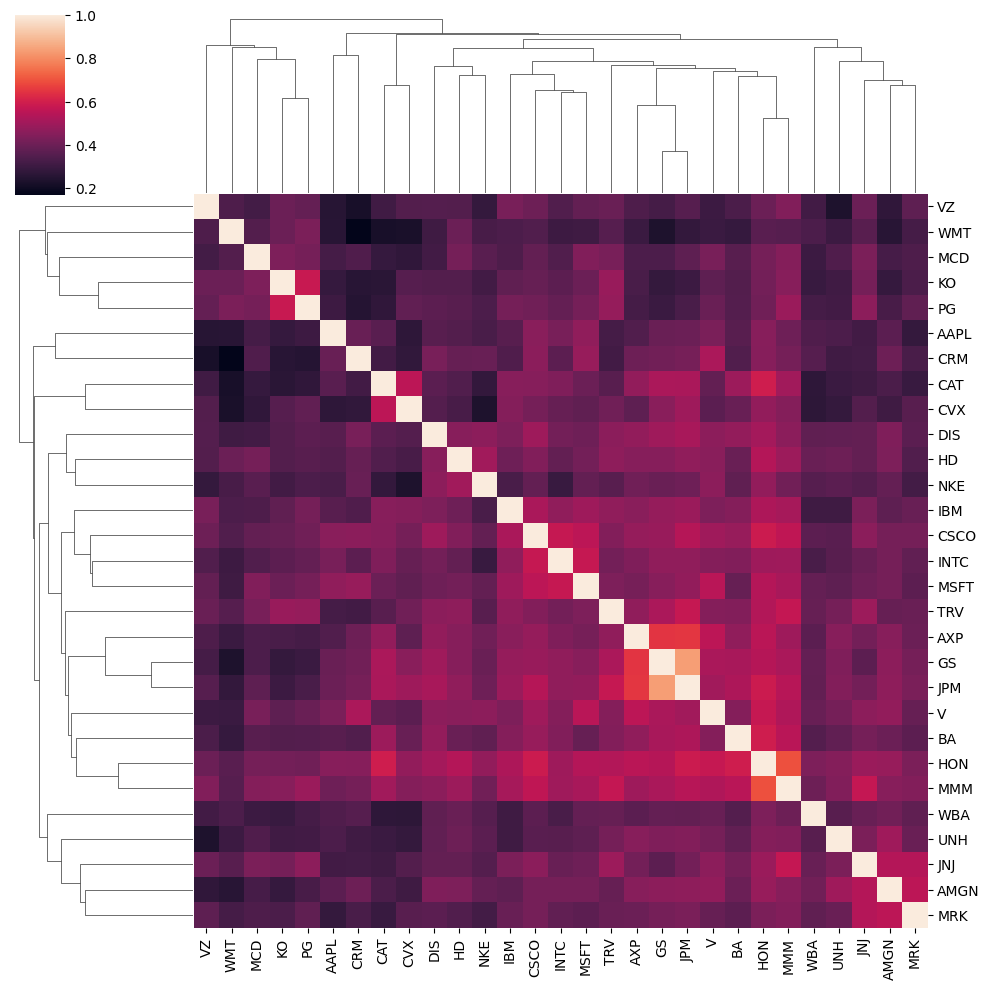

In [901]:
sns.clustermap(dji_train_corr);

In [928]:
dji_train_scaled

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,-1.835093,-0.889387,0.283254,0.514610,-0.095410,0.258440,-0.151938,0.116341,-0.267697,0.515046,...,0.447760,-0.664936,-0.269212,-0.189088,-0.299143,0.511415,-0.002037,-1.340830,0.220294,-0.400059
2014-01-06,0.363741,-0.679057,-0.072003,0.409386,-1.056751,-1.052417,0.066207,-0.234114,-0.442308,0.493425,...,-0.004230,-1.915231,-0.697490,0.274324,-0.392611,-1.096385,-0.611921,0.578371,0.394096,-0.654429
2014-01-07,-0.647096,1.889638,-0.394218,1.229203,0.197111,0.794277,1.243209,0.662721,0.645531,-0.518036,...,0.699507,0.591699,0.026824,1.247934,-0.766351,2.542133,0.632556,1.344713,0.458476,0.303990
2014-01-08,0.434305,-0.388053,0.273581,0.102210,0.127559,2.233923,-0.150749,-1.167876,-1.549762,0.021356,...,-0.644612,-1.630556,-0.481261,-1.970346,-1.172358,-1.112066,0.228196,-0.646375,2.335774,-0.909915
2014-01-09,-1.097689,1.888101,-0.600123,0.719020,0.435761,-0.755480,-0.925717,-0.020081,-0.487597,-0.502854,...,-0.551030,-0.639238,-0.039466,0.258525,0.061492,0.422633,-0.191012,-2.308820,2.253022,0.334142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,0.230017,-0.217851,-0.038865,-0.927000,1.009242,0.100611,-0.584882,2.573065,-0.165342,1.750801,...,0.825283,-0.101281,1.548637,0.163465,-0.791768,-0.373139,0.171822,0.465082,0.520525,-0.808593
2017-12-22,-0.073569,-0.146931,0.205658,-0.068963,0.495648,-0.638660,-0.014903,0.083310,-0.891359,-0.659061,...,-0.436014,-0.070836,-1.995031,0.628061,-0.117828,-0.764737,0.163103,0.338080,-0.598473,0.133758
2017-12-26,-2.108095,-0.176495,-0.194920,-0.013034,0.285607,-0.094049,-0.238962,0.625202,-0.569871,-0.424148,...,-0.058235,-0.192607,0.447336,0.465709,0.269900,-0.261849,0.178714,0.025980,0.583610,1.034726


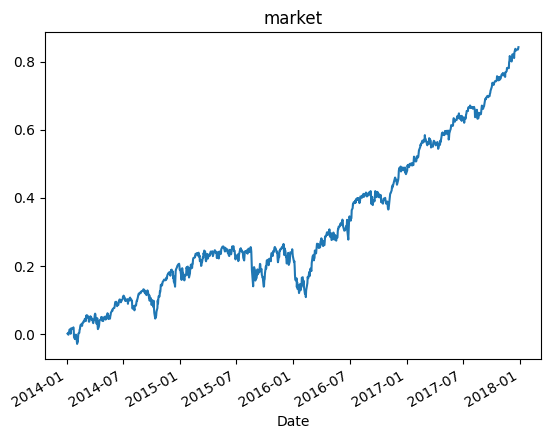

In [929]:
SP_train.mean(1).add(1).cumprod().sub(1).plot(title='market')
plt.show()

In [833]:
SP_eport.iloc[:,-1]

Date
2014-01-02   -101983.344327
2014-01-03   -102105.828254
2014-01-06   -101795.141423
2014-01-07   -102579.409288
2014-01-08   -102662.596367
                  ...      
2018-12-24   -163179.858347
2018-12-26   -170454.805581
2018-12-27   -172355.530745
2018-12-28   -172048.829260
2018-12-31   -173671.972168
Name: 469, Length: 1258, dtype: float64